In [1]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

import predict as pr

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('train_ajEneEa_cleaned.csv',index_col='id',low_memory=False,skipinitialspace=True)

In [3]:
df_test = pd.read_csv('test_v2akXPA_cleaned.csv',index_col='id',low_memory=False,skipinitialspace=True)

In [4]:
X = df_train.drop('stroke', axis=1) #dataframe
y = df_train['stroke'] #pandas seriesb

In [5]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,
30669,3.0,0,0,95.12,18.0,1,0,0,0,0,0,1,0,0,0
30468,58.0,1,0,87.96,39.2,1,0,1,0,1,0,0,1,1,0
16523,8.0,0,0,110.89,17.6,0,0,0,0,1,0,0,1,0,0
56543,70.0,0,0,69.04,35.9,0,0,1,0,1,0,0,0,0,0
46136,14.0,0,0,161.28,19.1,1,0,0,1,0,0,0,0,0,0


In [6]:
missing_values_count = X.isnull().sum()
missing_values_count[missing_values_count >0]

bmi    1462
dtype: int64

In [7]:
y.head()

id
30669    0
30468    0
16523    0
56543    0
46136    0
Name: stroke, dtype: int64

In [8]:
X_test = df_test #dataframe
X_test.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,
36306,80.0,0,0,83.84,21.1,1,0,1,0,1,0,0,1,0,0
61829,74.0,0,1,179.50,26.0,0,0,1,0,0,1,0,0,0,0
14152,14.0,0,0,95.16,21.2,0,0,0,0,0,0,1,0,0,0
12997,28.0,0,0,94.76,23.4,1,0,0,0,1,0,0,1,0,0
40801,63.0,0,0,83.57,27.6,0,0,1,0,0,0,0,0,1,0


In [9]:
missing_values_count = X_test.isnull().sum()
missing_values_count[missing_values_count >0]

bmi    591
dtype: int64

In [10]:
X_test.index.values

array([36306, 61829, 14152, ..., 29839,  6438, 16770], dtype=int64)

## XGBoost

In [11]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [12]:
from imblearn.pipeline import Pipeline as pl
# Steps for pipeline
steps = [
         ("model", XGBClassifier(random_state=40))]
pipe = pl(steps)

In [13]:
param_grid = {
                'model__objective' : ['binary:logistic'],
                'model__n_estimators': [60],
                'model__max_depth': [2],
                'model__min_child_weight': [0.5],    
                'model__scale_pos_weight': [98],
                'model__learning_rate':[0.1],
                'model__subsample': [1],
                'model__gamma' : [0.3],
                'model__colsample_bytree' : [0.8],
                'model__reg_alpha':[100]
             }
print(param_grid)

{'model__objective': ['binary:logistic'], 'model__n_estimators': [60], 'model__max_depth': [2], 'model__min_child_weight': [0.5], 'model__scale_pos_weight': [98], 'model__learning_rate': [0.1], 'model__subsample': [1], 'model__gamma': [0.3], 'model__colsample_bytree': [0.8], 'model__reg_alpha': [100]}


In [14]:
#from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                   random_state=42, stratify=y)

In [15]:
grid = GridSearchCV(pipe, param_grid,cv=5, scoring='roc_auc',iid=False,verbose = 3, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=40, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'model__objective': ['binary:logistic'], 'model__n_estimators': [60], 'model__max_depth': [2], 'model__min_child_weight': [0.5], 'model__scale_pos_weight': [98], 'model__learning_rate': [0.1], 'model__subsample': [1], 'model__gamma': [0.3], 'model__colsample_bytree': [0.8], 'model__reg_alpha': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=3)

In [16]:
print(grid.best_score_)
print(grid.best_params_)

0.8660562436638065
{'model__colsample_bytree': 0.8, 'model__gamma': 0.3, 'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__min_child_weight': 0.5, 'model__n_estimators': 60, 'model__objective': 'binary:logistic', 'model__reg_alpha': 100, 'model__scale_pos_weight': 98, 'model__subsample': 1}


C:\Users\SriramASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#####################
Test data
#####################
F1:  0.07953890489913544
Cohen Kappa:  0.046610377863745
Brier:  0.36797235023041475
LogLoss:  0.6417814218917699
ROC_AUC:  0.8450958104372507


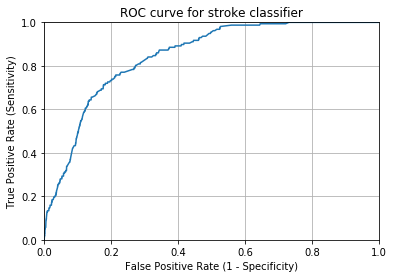

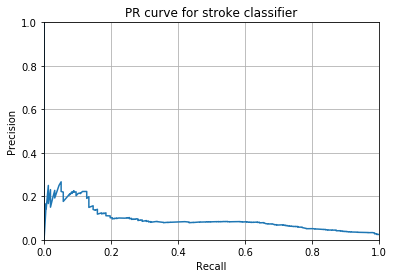

Classification Report :
---------------------
             precision    recall  f1-score   support

          0       1.00      0.63      0.77      8523
          1       0.04      0.88      0.08       157

avg / total       0.98      0.63      0.76      8680

Confusion Matrix :
----------------


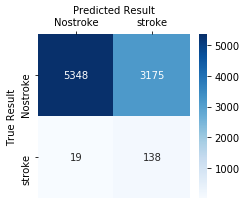

In [17]:
# call custom function from predict.py (has to be in the same directory)
pr.predict_test(X_test=X_val,y_test=y_val,model=grid)

In [18]:
y_pred = grid.predict(X_test)

C:\Users\SriramASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
x=X_test.index.values

In [20]:
y=y_pred

In [21]:
df_out = pd.DataFrame({'id':x, 'stroke':y})

In [22]:
df_out.set_index('id',inplace=True)

In [23]:
df_out.head()

,stroke
id,
36306,1
61829,1
14152,0
12997,0
40801,1


In [24]:
df_out['stroke'].unique()

array([1, 0], dtype=int64)

In [25]:
df_out.to_csv('test_Log_XGB.csv')

In [26]:
model = XGBClassifier(max_depth=2, min_child_weight=0.5,scale_pos_weight=100, n_jobs=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=0.5, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=100, seed=None,
       silent=True, subsample=1)

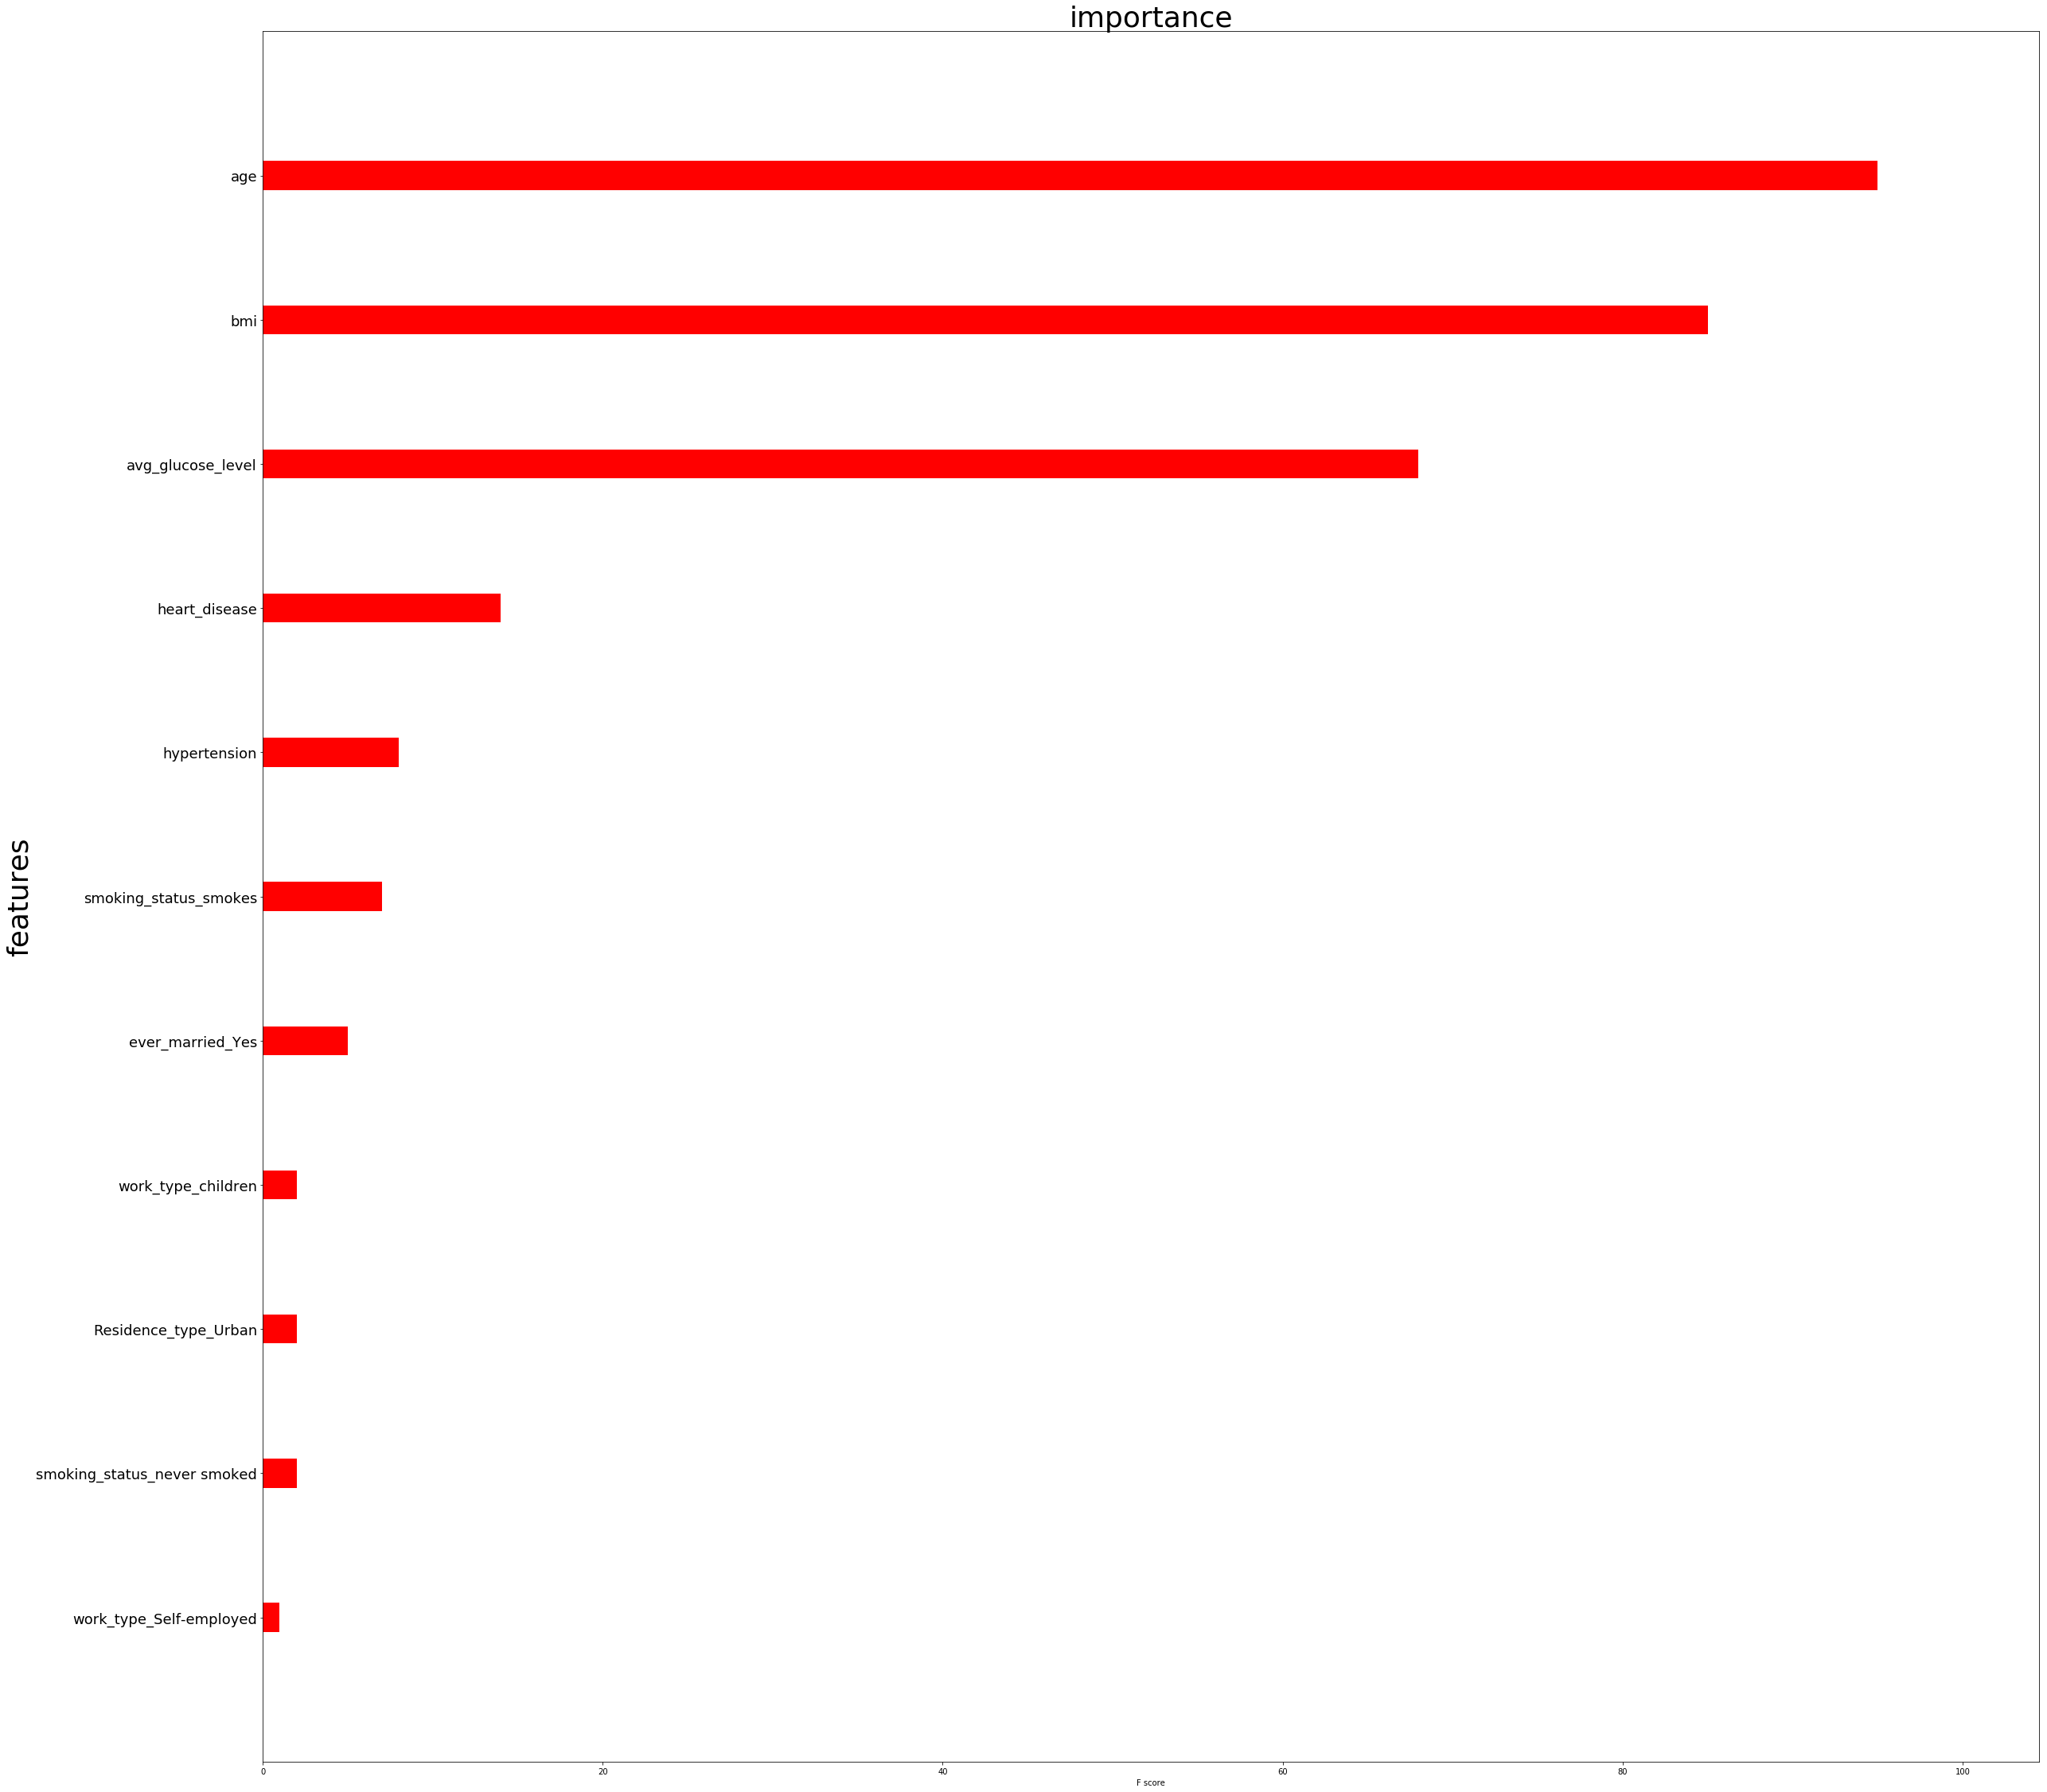

In [27]:
from xgboost import plot_importance
%matplotlib inline
from matplotlib import pyplot as plt

# feature importance
fig, ax = plt.subplots(figsize=(40, 40))
plot_importance(model, color='red', grid=False, show_values=False, ax=ax)
plt.title('importance', fontsize = 36)
plt.yticks(fontsize = 18)
plt.ylabel('features', fontsize = 36)